# Week 2 - Connect Tiki Scraper to PostgreSQL database

## Introduction

PostgreSQL is a free and open-source relational database management system. Using a database instead of regular spreadsheet will allow us to store a larger amount of data as well as offer a much higher capacity to later process our data. 

Instead of exporting the scraped data to a dataframe like we did in Week 1, this time we will push our data to a PostgreSQL database. 

PostgreSQL databases run locally and therefore each of us will need to install and create our own PostgreSQL database.

## Submission Guide
- Create a copy of this Jupyter Notebook
- Create a Github repository for your project
- Upload the Jupyter Notebook with your solution to your Github repository
- Submit your works through this [Google Form](https://forms.gle/6cgzgw4uKTTRZTri7).


# Your tasks: Replace "__" with the correct code

## Update the Scraper

Besides `pandas`, `requests` and `BeautifulSoup`, we will be using another library called `psycopg2` to interact with our PostgreSQL database.

In [3]:
# Import libraries
import pandas as pd
import requests
import psycopg2
from bs4 import BeautifulSoup

In [4]:
# Parser function to retrieve and parse the HTML code of a website 
def parser(url):
    
    # Plain HTML code
    plain = requests.get(url).text
    
    # Parser
    s = BeautifulSoup(plain, "html.parser")
    
    return s

In [5]:
# Function to get all URLs of categories on Tiki
def get_urls():
    
    url = 'https://tiki.vn/'
          
    # Run Parser on Tiki
    s = parser(url)
    
    # Initialize an empty list of category 
    category_list = []

    # Scrape
    
    # through the navigator bar on Tiki homepage
    for i in s.findAll('a',{'class':'MenuItem__MenuLink-tii3xq-1 efuIbv'}):
        
        # Get the category value
        category = i.find('span',{'class':'text'}).text 
        
        # Get the url value
        url = i['href'] + "&page=1"
         
        # Add category and url values to list
        category_list.append((category, url))
        
    return category_list

## Connect to PostgreSQL Database

The function `get_connection()` creates a connection to our local PostgreSQL database. 

Change the arguments of `psycopg2.connect()` with your information.

In [6]:
# Function to create connection to our PostgreSQL database
def get_connection():
    connection = psycopg2.connect(user = "postgres",
                                  password = 'tu',
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "tiki")
    return connection

### _Test the function_

In [7]:
get_connection()

<connection object at 0x000001EEC9DF67B8; dsn: 'user=postgres password=xxx dbname=tiki host=127.0.0.1 port=5432', closed: 0>

## Create new table in PostgreSQL Database

`create_products_table()` creates an empty table in our local PostgreSQL database with predefined columns:
* product_id: varchar (20)
* product_seller_id: varchar (20)
* title: text
* price: integer
* img_url: text
* category: text

The `cursor` allows Python code to execute PostgreSQL command during our session (connection). `cursor` is always bound to our `connection`. 

In [6]:
# Function to create an empty `products` table in our database if it doesn't exist yet
def create_products_table():
    
    print('INFO create_products_table(): Create table products')
    
    try:
        # Create connection & cursor
        connection = get_connection()
        cursor = connection.cursor()
        
        # Execute the query
        cursor.execute('''CREATE TABLE IF NOT EXISTS products (
                            product_id INTEGER PRIMARY KEY,
                            product_seller_id TEXT,
                            title TEXT,
                            price TEXT,
                            img_url TEXT,                           
                            tikinow TEXT,
                            rating TEXT,
                            review TEXT,
                            category TEXT
                            );''')
        
        # Commit the changes made to our database
        connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("ERROR create_products_table(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        return
    
    finally:
    
        # Close the connection & cursor
        cursor.close
        connection.close

### _Test the function_

In [15]:
create_products_table()

INFO create_products_table(): Create table products


## Insert data to PostSQL Database

`insert_data_to_db` function inserts the data row into our PostgreSQL table. It takes two arguments: `data` being the results the scrape() function and `table_name` being the table in our database that we want to insert `data` to.

This function replaces the step in `scrape_all()` where we add the result of `scrape(cat, url)` to `results`. See changes in funciton `scrape_all()` below.

In [16]:
# Function to insert new data to our table
def insert_data_to_db(data, table_name):
    
    print('INFO insert_data_to_db(): Insert data to DB')
    
    try:
        # Create connection & cursor 
        connection = get_connection()
        cursor = connection.cursor()
        
        # For each row (product) in data (product page),...
        for row in data:
            cursor.execute('SELECT 1 FROM products WHERE product_id = ' + row[0]);
            check_exist = cursor.fetchall()
            
            if len(check_exist) == 0:
                
                # Create the query to insert product information to 'table_name'  
                # Execute the query
                cursor.execute('INSERT INTO products VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)', row)

                # Commit the changes made to our database
                connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("ERROR save_data_to_db(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        
    finally:
        
        # Close the connection & cursor
        cursor.close()
        connection.close()

To check if we have successfully created table `products`, go to your terminal, connect to your PostgreSQL database `psql -U [user_name] tiki` then enter `\d products`

`select_data_from_db()` will get all the data from table `products` to help us see if your scraper works.

In [8]:
# Function to get all data from table 'products'
def select_data_from_db():
    
    try:
        # Create connection & cursor 
        connection = get_connection()
        cursor = connection.cursor()
        
        # Get all data from table 'products'
        cursor.execute('SELECT * FROM products;')      
        
        # Fetch (Collect) the data and save them in 'data'
        data = cursor.fetchall()
        
        return data 

    except (Exception, psycopg2.Error) as error :
        print ("ERROR save_data_to_db(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        
    finally:
        
        # Close the connection & cursor
        cursor.close()
        connection.close()

The `scrape(cat, url)` function is the same as the one we created in Week 1.

In [18]:
# Web scrape function
def scrape(cat, url):
    
    # Initialize empty 'results' list
    results = []
   
    # Run Parser on the product page
    s = parser(url)
    
    # Find all tags <div class='product-item'> and store them in 'prodct_items' list, each tag represent a product
    product_items = s.findAll('div',{'class':'product-item'})
    
   # if len(product_items[i].select('span.rating-content span[style]')) > 0:
    # rating = rating[0]["style"][len("width:"):]
    # If the tag list is empty (i.e. the page doesn't have any product), return an empty list.
    if len(product_items) == 0:
        return []

    # If the tag list is not empty (i.e. the page has products),...
    else:
        tiki_now = 0
        review_total = 0
        
        # Iterate through all product and store the product information in the 'row' list
        for i in range(len(product_items)):
            rating = 0
            if len(product_items[i].select(".rating-content span")) > 0:
                rating = product_items[i].select_one(".rating-content span")["style"].split(':')[1].replace("%", "")
            
            if len(product_items[i].findAll('i',{'class':'tikicon icon-tikinow'})) > 0:
                tiki_now = 1
            
            if len(product_items[i].findAll('div',{'class':'review-wrap'})) > 0:
                review_total = product_items[i].find('p',{'class':'review'}).string.replace(" nhận xét)","").replace("(","")
                
            row = [product_items[i]['data-id'],
                   product_items[i]['data-seller-product-id'], 
                   product_items[i]['data-title'],
                   product_items[i]['data-price'], 
                   product_items[i].find('img',{'class':'product-image img-responsive'})['src'],  
                   tiki_now,
                   rating,
                   review_total,
                   product_items[i]['data-category']]
            # Add the product information of each product into 'results' list
            results.append(row)
    # Return the list `results`   
    return results

In [19]:
scrape_all()

INFO scrape_all(): Start scraping
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=2
Add next page 2
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=3
Add next page 3
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=4
Add next page 4
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=5
Add next page 5
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=46
Add next page 46
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=47
Add next page 47
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=48
Add next page 48
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=49
Add next page 49
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=50
Add next page 50
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/vouch

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=90
Add next page 90
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=91
Add next page 91
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=92
Add next page 92
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=93
Add next page 93
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=94
Add next page 94
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/vouch

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=38
Add next page 38
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=39
Add next page 39
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=40
Add next page 40
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=41
Add next page 41
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=42
Add next page 42
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=85
Add next page 85
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=86
Add next page 86
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=87
Add next page 87
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=88
Add next page 88
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=89
Add next page 89
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=132
Add next page 132
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=133
Add next page 133
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=134
Add next page 134
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=135
Add next page 135
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=136
Add next page 136
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=179
Add next page 179
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=180
Add next page 180
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=181
Add next page 181
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=182
Add next page 182
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=183
Add next page 183
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=18
Add next page 18
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=19
Add next page 19
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=20
Add next page 20
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=21
Add next page 21
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=22
Add next page 22
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=23
Add next page 23
Scraping

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=67
Add next page 67
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=68
Add next page 68
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=69
Add next page 69
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=70
Add next page 70
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=71
Add next page 71
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=72
Add next page 72
Scraping

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=116
Add next page 116
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=117
Add next page 117
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=118
Add next page 118
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=119
Add next page 119
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=120
Add next page 120
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=121
Add next page 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=164
Add next page 164
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=165
Add next page 165
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=166
Add next page 166
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=167
Add next page 167
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=168
Add next page 168
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=169
Add next page 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=4
Add next page 4
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=5
Add next page 5
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=7
Add next page 7
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=8
Add next page 8
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=50
Add next page 50
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=51
Add next page 51
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=52
Add next page 52
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=53
Add next page 53
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=54
Add next page 54
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=96
Add next page 96
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=97
Add next page 97
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=98
Add next page 98
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=99
Add next page 99
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=100
Add next page 100
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.85

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=141
Add next page 141
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=142
Add next page 142
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=143
Add next page 143
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=144
Add next page 144
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=145
Add next page 145
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=186
Add next page 186
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=187
Add next page 187
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=188
Add next page 188
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=189
Add next page 189
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=190
Add next page 190
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=25
Add next page 25
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=26
Add next page 26
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=27
Add next page 27
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=28
Add next page 28
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=29
Add next page 29
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=30
Add next page 30
Scraping 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=74
Add next page 74
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=75
Add next page 75
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=76
Add next page 76
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=77
Add next page 77
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=78
Add next page 78
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=79
Add next page 79
Scraping 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=122
Add next page 122
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=123
Add next page 123
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=124
Add next page 124
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=125
Add next page 125
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=126
Add next page 126
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=127
Add next page 1

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=170
Add next page 170
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=171
Add next page 171
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=172
Add next page 172
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=173
Add next page 173
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=174
Add next page 174
Scraping Thể Thao - Dã Ngoại
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=175
Add next page 1

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=10
Add next page 10
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=11
Add next page 11
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=12
Add next page 12
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=13
Add next page 13
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=14
Add next page 14
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=15
Add next page 15

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=58
Add next page 58
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=59
Add next page 59
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=60
Add next page 60
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=61
Add next page 61
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=62
Add next page 62
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=63
Add next page 63

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=106
Add next page 106
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=107
Add next page 107
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=108
Add next page 108
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=109
Add next page 109
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=110
Add next page 110
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=111
Add n

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=154
Add next page 154
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=155
Add next page 155
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=156
Add next page 156
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=157
Add next page 157
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=158
Add next page 158
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=159
Add n

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=202
Add next page 202
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=203
Add next page 203
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=204
Add next page 204
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=205
Add next page 205
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=206
Add next page 206
Scraping Thời trang - Phụ kiện
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=207
Add n

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=41
Add next page 41
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=42
Add next page 42
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=43
Add next page 43
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=44
Add next page 44
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=45
Add next page 45
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_ou

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=88
Add next page 88
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=89
Add next page 89
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=90
Add next page 90
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=91
Add next page 91
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=92
Add next page 92
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_ou

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=134
Add next page 134
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=135
Add next page 135
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=136
Add next page 136
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=137
Add next page 137
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=138
Add next page 138
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_m

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=180
Add next page 180
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=181
Add next page 181
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=182
Add next page 182
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=183
Add next page 183
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=184
Add next page 184
Scraping Làm Đẹp - Sức Khỏe
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_m

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=19
Add next page 19
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=20
Add next page 20
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=21
Add next page 21
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=22
Add next page 22
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=23
Add next page 23
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=24
Add next page 24
Scraping Đồ chơi, Mẹ & B

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=69
Add next page 69
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=70
Add next page 70
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=71
Add next page 71
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=72
Add next page 72
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=73
Add next page 73
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=74
Add next page 74
Scraping Đồ chơi, Mẹ & B

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=118
Add next page 118
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=119
Add next page 119
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=120
Add next page 120
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=121
Add next page 121
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=122
Add next page 122
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=123
Add next page 123
Scraping Đồ 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=167
Add next page 167
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=168
Add next page 168
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=169
Add next page 169
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=170
Add next page 170
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=171
Add next page 171
Scraping Đồ chơi, Mẹ & Bé
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=172
Add next page 172
Scraping Đồ 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=7
Add next page 7
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=8
Add next page 8
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=9
Add next page 9
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=10
Add next page 10
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=11
Add next page 11
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=52
Add next page 52
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=53
Add next page 53
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=54
Add next page 54
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=55
Add next page 55
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=56
Add next page 56
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c438

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=97
Add next page 97
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=98
Add next page 98
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=99
Add next page 99
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=100
Add next page 100
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=101
Add next page 101
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=142
Add next page 142
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=143
Add next page 143
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=144
Add next page 144
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=145
Add next page 145
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=146
Add next page 146
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-o

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=187
Add next page 187
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=188
Add next page 188
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=189
Add next page 189
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=190
Add next page 190
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=191
Add next page 191
Scraping Hàng Tiêu Dùng - Thực Phẩm
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/bach-hoa-o

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=25
Add next page 25
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=26
Add next page 26
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=27
Add next page 27
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=28
Add next page 28
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=29
Add next page 29
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&p

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=72
Add next page 72
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=73
Add next page 73
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=74
Add next page 74
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=75
Add next page 75
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=76
Add next page 76
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&p

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=119
Add next page 119
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=120
Add next page 120
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=121
Add next page 121
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=122
Add next page 122
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=123
Add next page 123
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_ou

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=166
Add next page 166
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=167
Add next page 167
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=168
Add next page 168
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=169
Add next page 169
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=170
Add next page 170
Scraping Nhà Cửa Đời Sống
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_ou

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=5
Add next page 5
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=7
Add next page 7
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=8
Add next page 8
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=9
Add next page 9
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=10
Add next page 10
Scraping Điện Gia D

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=54
Add next page 54
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=55
Add next page 55
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=56
Add next page 56
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=57
Add next page 57
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=58
Add next page 58
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=59
Add next page 59
Scraping 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=103
Add next page 103
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=104
Add next page 104
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=105
Add next page 105
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=106
Add next page 106
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=107
Add next page 107
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=108
Add next page 1

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=151
Add next page 151
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=152
Add next page 152
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=153
Add next page 153
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=154
Add next page 154
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=155
Add next page 155
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=156
Add next page 1

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=199
Add next page 199
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=200
Add next page 200
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=201
Add next page 201
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=202
Add next page 202
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=203
Add next page 203
Scraping Điện Gia Dụng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=204
Add next page 2

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=40
Add next page 40
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=41
Add next page 41
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=42
Add next page 42
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=43
Add next page 43
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=44
Add next page 44
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=45
Add next page 45
Scraping Máy Ản

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=89
Add next page 89
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=90
Add next page 90
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=91
Add next page 91
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=92
Add next page 92
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=93
Add next page 93
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=94
Add next page 94
Scraping Máy Ản

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=138
Add next page 138
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=139
Add next page 139
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=140
Add next page 140
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=141
Add next page 141
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=142
Add next page 142
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=143
Add next page 143
Scr

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=186
Add next page 186
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=187
Add next page 187
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=188
Add next page 188
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=189
Add next page 189
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=190
Add next page 190
Scraping Máy Ảnh - Quay Phim
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=191
Add next page 191
Scr

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=32
Add next page 32
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=33
Add next page 33
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=34
Add next page 34
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=35
Add next page 35
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=36
Add next page 36
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=78
Add next page 78
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=79
Add next page 79
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=80
Add next page 80
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=81
Add next page 81
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=82
Add next page 82
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=124
Add next page 124
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=125
Add next page 125
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=126
Add next page 126
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=127
Add next page 127
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=128
Add next page 128
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=169
Add next page 169
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=170
Add next page 170
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=171
Add next page 171
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=172
Add next page 172
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=173
Add next page 173
Scraping Laptop - Thiết bị IT
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/laptop-may-vi-tinh/c1846?

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=7
Add next page 7
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=8
Add next page 8
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=9
Add next page 9
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=10
Add next page 10
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thi

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=50
Add next page 50
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=51
Add next page 51
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=52
Add next page 52
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=53
Add next page 53
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=54
Add next page 54
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tik

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=94
Add next page 94
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=95
Add next page 95
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=96
Add next page 96
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=97
Add next page 97
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=98
Add next page 98
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tik

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=137
Add next page 137
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=138
Add next page 138
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=139
Add next page 139
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=140
Add next page 140
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=141
Add next page 141
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
h

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=180
Add next page 180
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=181
Add next page 181
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=182
Add next page 182
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=183
Add next page 183
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=184
Add next page 184
Scraping Phụ Kiện - Thiết Bị Số
INFO insert_data_to_db(): Insert data to DB
h

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=16
Add next page 16
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=17
Add next page 17
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=18
Add next page 18
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=19
Add next page 19
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=20
Add next page 20
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-n

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=61
Add next page 61
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=62
Add next page 62
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=63
Add next page 63
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=64
Add next page 64
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=65
Add next page 65
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-n

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=106
Add next page 106
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=107
Add next page 107
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=108
Add next page 108
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=109
Add next page 109
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=110
Add next page 110
Scraping Điện Tử - Điện Lạnh
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/tivi-

Add next page 22
Task completed!


There are a few changes we will make to our `scrape_all()` function:
* Instead of initializing an empty `results` list, we will first run `create_products_table()` to create the `products` table in our database if it doesn't exist yet.
* Instead of add the result of `scrape(cat, url)` to `results`, we will add it directly to our table using `insert_data_to_db(data, table_name)`
* Since we have already inserted data to the `products` table while the function runs, we won't need to return the list `results`

In [21]:
# Run scrape fuction on every page

def scrape_all():
    print('INFO scrape_all(): Start scraping')
    
    # Initialize 'queue' list with the results of get_urls()
    queue = get_urls()
    
    # Create table `products` if it doesn't exist yet
    # results = []  <-- This is what we did in the first week
    results = []
    
    # While there are items in `queue`,...
    while len(queue) != 0:
        
      # `url` is set to the url of last item in `queue`
        url = queue[-1][-1]
      
      # `cat` is set to the category of last item in `queue`
        cat = queue[-1][0]
    
      # Remove the last item in queue
        queue = queue[:-1]

        print('Scraping', cat)

      # Run scrape(cat, url) with given `cat` and `url`
        new_rows = scrape(cat, url)

      # If the result of scrape(cat, url) is not an empty list (i.e. the page has products),...  
        if len(new_rows) != 0:
        
            # Insert the result of scrape(cat, url) to table `product`
            # results += new_rows  <-- This is what we did in the first week
            insert_data_to_db(new_rows, 'products')
            results += new_rows
            
            # Generate next page url 
            page = int(url[url.rfind("=")+1:])+1
            url = url[:url.rfind("=")+1] + str(page)
            
            print(url)
            
            # Use this to limit our scraper to scrape only the first 10 pages of each category
            # We do this to test our scraper with a smaller task first before running through every product page
            #if page < 10:
            
            # Add the new page url to the end of list `queue`
            queue.append((cat, url))
            
        print('Add next page', page)
    
    print('Task completed!')

### _Test the function_

In [22]:
scrape_all()

INFO scrape_all(): Start scraping
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=2
Add next page 2
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=3
Add next page 3
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=4
Add next page 4
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=5
Add next page 5
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=46
Add next page 46
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=47
Add next page 47
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=48
Add next page 48
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=49
Add next page 49
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=50
Add next page 50
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/vouch

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=90
Add next page 90
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=91
Add next page 91
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=92
Add next page 92
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=93
Add next page 93
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=94
Add next page 94
Scraping Voucher - Dịch Vụ - Thẻ Cào
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/vouch

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=38
Add next page 38
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=39
Add next page 39
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=40
Add next page 40
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=41
Add next page 41
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=42
Add next page 42
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=85
Add next page 85
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=86
Add next page 86
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=87
Add next page 87
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=88
Add next page 88
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=89
Add next page 89
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=132
Add next page 132
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=133
Add next page 133
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=134
Add next page 134
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=135
Add next page 135
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=136
Add next page 136
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=179
Add next page 179
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=180
Add next page 180
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=181
Add next page 181
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=182
Add next page 182
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=183
Add next page 183
Scraping Sách, VPP & Quà Tặng
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=18
Add next page 18
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=19
Add next page 19
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=20
Add next page 20
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=21
Add next page 21
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=22
Add next page 22
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=23
Add next page 23
Scraping

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=67
Add next page 67
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=68
Add next page 68
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=69
Add next page 69
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=70
Add next page 70
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=71
Add next page 71
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=72
Add next page 72
Scraping

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=116
Add next page 116
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=117
Add next page 117
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=118
Add next page 118
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=119
Add next page 119
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=120
Add next page 120
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=121
Add next page 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=164
Add next page 164
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=165
Add next page 165
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=166
Add next page 166
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=167
Add next page 167
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=168
Add next page 168
Scraping Hàng quốc tế
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=169
Add next page 

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=4
Add next page 4
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=5
Add next page 5
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=6
Add next page 6
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=7
Add next page 7
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=8
Add next page 8
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=50
Add next page 50
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=51
Add next page 51
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=52
Add next page 52
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=53
Add next page 53
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=54
Add next page 54
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594

INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=96
Add next page 96
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=97
Add next page 97
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=98
Add next page 98
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=99
Add next page 99
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=100
Add next page 100
Scraping Xe Máy, Ô tô, Xe Đạp
INFO insert_data_to_db(): Insert data to DB
https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.85

KeyboardInterrupt: 

### _Test the results by getting all data in table `products` and put them in a `pandas` dataframe_

In [27]:
data = select_data_from_db()
df = pd.DataFrame(data, columns = ['product_id', 'seller_id', 'title', 'price', 'image_url', 'tikinow', 'rating', 'review', 'category'])
df

,product_id,seller_id,title,price,image_url,tikinow,rating,review,category
0,21534194,21534195,BA GÁC NƯỚNG & BIA - COMBO NƯỚNG BA GÁC ĐẶC BI...,320000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Nhà hàng
1,23264624,23264630,Capella Park View - Buffet Chay Mùa Vu Lan Hơn...,189000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
2,16563156,16563157,Aka House - Đại Tiệc Buffet Nướng & Lẩu Nhật B...,229000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
3,20475731,20475732,"Kohaku Hotpot - Buffet Lẩu Nướng Hải Sản, Bò M...",279000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,100,1,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
4,7063331,7063333,CGV E-Voucher Vé Xem Phim 2D,88000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,80,143,Voucher - Dịch vụ/Sự kiện - Giải trí/Ca nhạc -...
5,11587220,11587221,Vé Tham Quan Bảo Tàng Tranh 3D Artinus (Quận 7...,89000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,83,11,Voucher - Dịch vụ/Sự kiện - Giải trí/Vui chơi ...
6,1559415,1559417,Phiếu Quà Tặng Tiki 100.000đ,100000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,98,163,Voucher - Dịch vụ/Phiếu quà tặng
7,1559411,1559413,Phiếu Quà Tặng Tiki 50.000đ,50000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,96,53,Voucher - Dịch vụ/Phiếu quà tặng
8,16056469,16056470,Vé Bảo Tàng Tranh 3D Art In Paradise Đà Nẵng,87500,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,100,1,Voucher - Dịch vụ/Du lịch - Khách sạn/Vé tham ...
9,14615078,14615079,Lotte Cinema E-voucher Vé Xem Phim 2D - Áp Dụn...,69000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,1,Voucher - Dịch vụ/Sự kiện - Giải trí/Ca nhạc -...


Alternatively, you can connect to your PostgreSQL database `psql -U [user_name] tiki` and run query `SELECT * FROM products;`

# WEEK 2 PROJECT - DATA ANALYSIS OF TIKI.VN

## Chi Lan - Hanh Tu

### Introduction by Tu 

Tiki.vn is the fastest-growing e-commerce website in Vietnam. So let try to scarp the data of the products from tiki and find some clues.
Let's go




In [1]:
* Let import the essential libraries first:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [9]:
* And start our cute panda to help us with creating the dataframe:

data = select_data_from_db()
df = pd.DataFrame(data, columns = ['product_id', 'seller_id', 'title', 'price', 'image_url', 'tikinow', 'rating', 'review', 'category'])
df

,product_id,seller_id,title,price,image_url,tikinow,rating,review,category
0,21534194,21534195,BA GÁC NƯỚNG & BIA - COMBO NƯỚNG BA GÁC ĐẶC BI...,320000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Nhà hàng
1,23264624,23264630,Capella Park View - Buffet Chay Mùa Vu Lan Hơn...,189000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
2,16563156,16563157,Aka House - Đại Tiệc Buffet Nướng & Lẩu Nhật B...,229000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,0,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
3,20475731,20475732,"Kohaku Hotpot - Buffet Lẩu Nướng Hải Sản, Bò M...",279000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,100,1,Voucher - Dịch vụ/Nhà hàng - Ăn uống/Buffet/Bu...
4,7063331,7063333,CGV E-Voucher Vé Xem Phim 2D,88000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,80,143,Voucher - Dịch vụ/Sự kiện - Giải trí/Ca nhạc -...
5,11587220,11587221,Vé Tham Quan Bảo Tàng Tranh 3D Artinus (Quận 7...,89000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,83,11,Voucher - Dịch vụ/Sự kiện - Giải trí/Vui chơi ...
6,1559415,1559417,Phiếu Quà Tặng Tiki 100.000đ,100000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,98,163,Voucher - Dịch vụ/Phiếu quà tặng
7,1559411,1559413,Phiếu Quà Tặng Tiki 50.000đ,50000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,96,53,Voucher - Dịch vụ/Phiếu quà tặng
8,16056469,16056470,Vé Bảo Tàng Tranh 3D Art In Paradise Đà Nẵng,87500,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,100,1,Voucher - Dịch vụ/Du lịch - Khách sạn/Vé tham ...
9,14615078,14615079,Lotte Cinema E-voucher Vé Xem Phim 2D - Áp Dụn...,69000,https://salt.tikicdn.com/cache/200x200/ts/prod...,0,0,1,Voucher - Dịch vụ/Sự kiện - Giải trí/Ca nhạc -...


## Some overview of the stuff we got


In [25]:
df.info()
type(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124408 entries, 0 to 124407
Data columns (total 9 columns):
product_id    124408 non-null int64
seller_id     124408 non-null int64
title         124408 non-null object
price         124407 non-null float64
image_url     124408 non-null object
tikinow       124408 non-null int64
rating        124408 non-null int64
review        124408 non-null int64
category      124408 non-null object
dtypes: float64(1), int64(5), object(3)
memory usage: 8.5+ MB


pandas.core.frame.DataFrame

## Ok what is the most exensive product, the cheapest, and the mean one?

In [32]:
print(df['price'].max())
print(df['price'].min())
print(df['price'].mean())


649000000.0
0.0
1789813.4887104423


In [10]:
df.product_id=pd.to_numeric(df.product_id)

df.seller_id=pd.to_numeric(df.seller_id)

df.price=pd.to_numeric(df.price)

df.tikinow=pd.to_numeric(df.tikinow)

df.rating=pd.to_numeric(df.rating)

df.review=pd.to_numeric(df.review)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124408 entries, 0 to 124407
Data columns (total 9 columns):
product_id    124408 non-null int64
seller_id     124408 non-null int64
title         124408 non-null object
price         124407 non-null float64
image_url     124408 non-null object
tikinow       124408 non-null int64
rating        124408 non-null int64
review        124408 non-null int64
category      124408 non-null object
dtypes: float64(1), int64(5), object(3)
memory usage: 8.5+ MB


## As a typical guy who have a soft wallet, I'm quite sensitive about the price, so let's look at the price map of all products in the website.

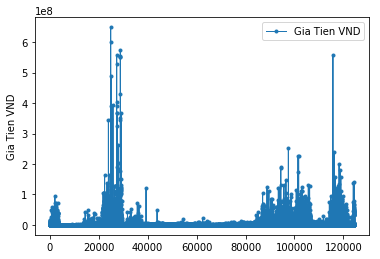

In [24]:
start, end = 0, 124407
fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'price'],
marker='.', linestyle='-', linewidth=1, label='Gia Tien VND')
ax.set_ylabel('Gia Tien VND')
ax.legend();

## How about a comparision between 'price', 'tikinow', 'rating', and 'review' data? 

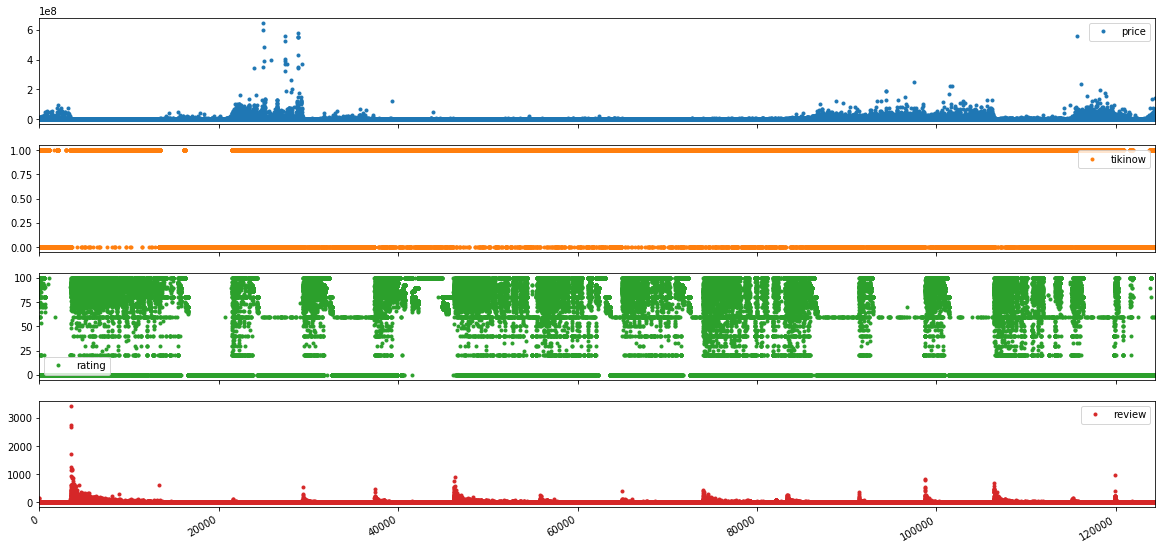

In [36]:
cols_plot = ['price', 'tikinow', 'rating', 'review']
axes = df[cols_plot].plot(marker='.', linestyle='None', figsize=(20, 10), subplots=True)